In [1]:
import pandas as pd
Y = pd.read_csv("/kaggle/input/nk-sec/Y_train_call.csv")
X = pd.read_csv("/kaggle/input/nk-sec/X_train .csv")

Y.insert(0, 'underlying', X['underlying'])

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, dual_annealing
# from sklearn.metrics import mean_squared_error # Not explicitly used for SVI fitting part
import warnings
warnings.filterwarnings('ignore')

# --- GPU Configuration ---
USE_GPU = False  # Set to True to attempt GPU usage, False to force CPU
cp = None
xp = np # Default to numpy

if USE_GPU:
    try:
        import cupy
        cp = cupy
        xp = cp
        print("✅ CuPy imported successfully. GPU operations enabled.")
        # Optional: Select a specific GPU if multiple are available
        # cp.cuda.Device(0).use()
    except ImportError:
        print("⚠️ CuPy could not be imported. Falling back to NumPy for all operations.")
        USE_GPU = False
        xp = np # Fallback to numpy
else:
    print("ℹ️ GPU usage is disabled by user. Using NumPy for all operations.")
    xp = np
# --- End GPU Configuration ---

class SVIModel:
    """SVI (Stochastic Volatility Inspired) model implementation (GPU/CPU compatible)"""

    @staticmethod
    def svi_variance(k, a, b, rho, m, sigma):
        """SVI total variance formula (uses global xp: cp or np for array operations)"""
        return a + b * (rho * (k - m) + xp.sqrt((k - m)**2 + sigma**2))

    @staticmethod
    def svi_volatility(k, a, b, rho, m, sigma, T=7/365):
        """Convert SVI variance to volatility (uses global xp: cp or np)"""
        variance = SVIModel.svi_variance(k, a, b, rho, m, sigma)
        return xp.sqrt(xp.maximum(variance / T, 1e-8))

    @staticmethod
    def fit_svi(strikes, ivs, forward, time_to_expiry=7/365, fit_strategy='robust'):
        """Fit SVI model to market data with adaptive strategy (GPU/CPU aware)"""

        strikes_np = np.asarray(strikes)
        ivs_np = np.asarray(ivs)
        log_moneyness_np = np.log(strikes_np / forward)
        total_variances_np = (ivs_np**2) * time_to_expiry

        current_device_xp = xp
        if USE_GPU and cp:
            log_moneyness_device = cp.asarray(log_moneyness_np)
            total_variances_device = cp.asarray(total_variances_np)
        else:
            log_moneyness_device = log_moneyness_np
            total_variances_device = total_variances_np
            current_device_xp = np

        def objective(params):
            a, b, rho, m, sigma = params
            if not (b >= 0): return 1e10
            if not (abs(rho) < 1): return 1e10
            if not (sigma > 1e-8): return 1e10
            
            sqrt_1_minus_rho_sq_val = np.sqrt(max(0, 1 - rho**2))
            if not (a + b * sigma * sqrt_1_minus_rho_sq_val > 1e-10): return 1e10
            if not (a + b * sigma * (sqrt_1_minus_rho_sq_val - rho) > 1e-10): return 1e10
            if not (b * (1 + abs(rho)) < 4.0): return 1e10

            try:
                fitted_vars = SVIModel.svi_variance(log_moneyness_device, a, b, rho, m, sigma)
                if current_device_xp.any(current_device_xp.isnan(fitted_vars)) or \
                   current_device_xp.any(fitted_vars <= 1e-10):
                    return 1e10
                weights = 1.0 / (total_variances_device + 1e-8)
                weighted_mse = current_device_xp.average((total_variances_device - fitted_vars)**2, weights=weights)
                final_rmse = current_device_xp.sqrt(weighted_mse)
                if USE_GPU and cp and isinstance(final_rmse, cp.ndarray):
                    return float(final_rmse.get())
                return float(final_rmse)
            except Exception:
                return 1e10

        iv_mean_np = np.mean(ivs_np) if len(ivs_np) > 0 else 0.2
        iv_std_np = np.std(ivs_np) if len(ivs_np) > 0 else 0.1
        k_range_np = np.max(log_moneyness_np) - np.min(log_moneyness_np) if len(log_moneyness_np) > 1 else 0.1
        min_log_m = np.min(log_moneyness_np) if len(log_moneyness_np) > 0 else -0.5
        max_log_m = np.max(log_moneyness_np) if len(log_moneyness_np) > 0 else 0.5

        bounds = [
            (1e-8, max(1e-7, iv_mean_np**2 * time_to_expiry * 2.0)),
            (1e-8, max(1e-7, iv_std_np * 4.0)),
            (-0.999, 0.999),
            (min_log_m - k_range_np, max_log_m + k_range_np),
            (1e-8, max(1e-7, k_range_np if k_range_np > 1e-4 else 0.5))
        ]
        for i in range(len(bounds)):
            if bounds[i][0] >= bounds[i][1]:
                bounds[i] = (bounds[i][0], bounds[i][0] + max(0.1, abs(bounds[i][0] * 0.1)))


        results = []
        opt_maxiter_robust = 1500
        opt_tol_robust = 1e-8
        opt_maxiter_fast = 750
        opt_tol_fast = 1e-7

        # --- Smart Initialization Logic ---
        smart_start_params = None
        if len(log_moneyness_np) > 0 and len(ivs_np) > 0:
            sorted_indices = np.argsort(log_moneyness_np)
            sorted_log_m = log_moneyness_np[sorted_indices]
            sorted_ivs = ivs_np[sorted_indices]
            atm_iv_val = np.interp(0, sorted_log_m, sorted_ivs,
                                left=sorted_ivs[0] if len(sorted_ivs) > 0 else 0.2,
                                right=sorted_ivs[-1] if len(sorted_ivs) > 0 else 0.2)
        else:
            atm_iv_val = 0.2
        
        _smart_start_params_unbounded = [
            atm_iv_val**2 * time_to_expiry * 0.8, # a
            0.1,                                 # b
            0.0,                                 # rho
            0.0,                                 # m (ATM)
            0.1                                  # sigma
        ]
        smart_start_params = [min(max(val, bounds[j][0]), bounds[j][1]) for j, val in enumerate(_smart_start_params_unbounded)]


        if fit_strategy == 'fast':
            try:
                result_lbfgsb_smart = minimize(
                    objective, smart_start_params, method='L-BFGS-B', bounds=bounds,
                    options={'ftol': opt_tol_fast, 'gtol': opt_tol_fast, 'maxiter': opt_maxiter_fast}
                )
                results.append(result_lbfgsb_smart)
            except Exception: pass
        
        elif fit_strategy == 'robust':
            try:
                result_de = differential_evolution(
                    objective, bounds, seed=42,
                    maxiter=opt_maxiter_robust, atol=opt_tol_robust, tol=opt_tol_robust,
                    workers=1 if USE_GPU and cp else -1,
                    polish=True
                )
                results.append(result_de)
            except Exception: pass

            try:
                result_da = dual_annealing(
                    objective, bounds, seed=42,
                    maxiter=opt_maxiter_robust,
                    local_search_options={'method': 'L-BFGS-B',
                                          'options': {'ftol': opt_tol_robust, 'gtol': opt_tol_robust, 'maxiter': opt_maxiter_robust//2}}
                )
                results.append(result_da)
            except Exception: pass
            
            # Optionally, add one smart L-BFGS-B if DE/DA didn't use it or if further refinement is desired
            # However, DE with polish and DA with local search are quite strong.
            # For this version, we rely on DE(polish) and DA for the robust strategy's local search.

        else:
            raise ValueError(f"Unknown fit_strategy: {fit_strategy}")

        if results:
            valid_results = [r for r in results if hasattr(r, 'success') and r.success and \
                             hasattr(r, 'fun') and r.fun is not None and r.fun < 1e9]
            if not valid_results:
                 valid_results = [r for r in results if hasattr(r, 'fun') and \
                                  r.fun is not None and r.fun < 1e9]
            if valid_results:
                best_result = min(valid_results, key=lambda x: x.fun)
                if hasattr(best_result, 'x'):
                    return best_result.x, best_result.fun
            elif results: 
                potential_best = [r for r in results if hasattr(r, 'x') and hasattr(r, 'fun') and r.fun is not None and r.fun < 1e9]
                if potential_best:
                    best_result = min(potential_best, key=lambda x: x.fun)
                    return best_result.x, best_result.fun
        return None, 1e10


class SVISmileFitter:
    """SVI-focused smile curve fitting with parameter storage and adaptive strategy."""
    def __init__(self, time_to_expiry=7/365, failure_threshold=5000):
        self.T = time_to_expiry
        self.underlying_col_name = 'underlying' # Default, can be updated
        self.FAILURE_THRESHOLD = failure_threshold

    def fit_and_store_parameters(self, df, underlying_col='underlying'):
        self.underlying_col_name = underlying_col 
        
        print(f"🚀 SVI Smile Curve Fitting with Parameter Storage (Adaptive Strategy)")
        print(f"Failure threshold to switch to robust fitting: {self.FAILURE_THRESHOLD}")
        print("=" * 70)
        
        result_df = df.copy()
        param_columns = ['svi_a', 'svi_b', 'svi_rho', 'svi_m', 'svi_sigma', 'svi_rmse', 'svi_success']
        for col in param_columns:
            result_df[col] = np.nan
            
        successful_fits = 0
        total_curves_attempted = 0
        all_rmses = []
        
        failed_fits_count = 0
        current_fit_strategy = 'fast'

        compute_backend = "CPU (NumPy)"
        if USE_GPU and cp:  compute_backend = "GPU (CuPy)"
        elif USE_GPU and not cp: compute_backend = "CPU (CuPy import failed, using NumPy)"

        print(f"📊 Processing {len(df)} rows using {compute_backend} backend. Initial strategy: '{current_fit_strategy}'.")
        
        for idx, row in df.iterrows():
            current_underlying_price = row[self.underlying_col_name]
            iv_columns = [col for col in df.columns if col.startswith('call_iv_')]
            
            strikes_list, ivs_list = [], []
            for col in iv_columns:
                strike_str = col.replace('call_iv_', '')
                try:
                    strike = float(strike_str)
                    iv = row[col]
                    if pd.notna(iv) and iv > 1e-4:
                        strikes_list.append(strike)
                        ivs_list.append(iv)
                except ValueError: continue
            
            if len(strikes_list) >= 5:
                total_curves_attempted += 1
                strikes_np_arr = np.array(strikes_list)
                ivs_np_arr = np.array(ivs_list)
                forward_price = current_underlying_price
                
                if failed_fits_count >= self.FAILURE_THRESHOLD and current_fit_strategy == 'fast':
                    current_fit_strategy = 'robust'
                    print(f"\n⚠️ Failed fits count ({failed_fits_count}) reached threshold ({self.FAILURE_THRESHOLD}).")
                    print(f"Switching to '{current_fit_strategy}' strategy for subsequent fits (Row index: {idx}).\n")
                
                try:
                    svi_params, svi_rmse = SVIModel.fit_svi(
                        strikes_np_arr, ivs_np_arr, forward_price, self.T, fit_strategy=current_fit_strategy
                    )
                    
                    if svi_params is not None and svi_rmse is not None and svi_rmse < 1e9:
                        result_df.loc[idx, ['svi_a', 'svi_b', 'svi_rho', 'svi_m', 'svi_sigma']] = svi_params
                        result_df.loc[idx, 'svi_rmse'] = svi_rmse
                        result_df.loc[idx, 'svi_success'] = True
                        successful_fits += 1
                        all_rmses.append(svi_rmse)
                        
                        if successful_fits > 0 and successful_fits % 50 == 0: # Print progress less frequently
                            current_avg_rmse = np.mean(all_rmses) if all_rmses else float('nan')
                            print(f"✅ Processed {successful_fits} successful fits (attempted: {total_curves_attempted}, strategy: '{current_fit_strategy}') | Avg RMSE: {current_avg_rmse:.8f}")
                    else:
                        result_df.loc[idx, 'svi_success'] = False
                        failed_fits_count += 1
                except Exception:
                    result_df.loc[idx, 'svi_success'] = False
                    failed_fits_count += 1
            else:
                result_df.loc[idx, 'svi_success'] = False

        avg_rmse_val, median_rmse_val, min_rmse_val, max_rmse_val = np.nan, np.nan, np.nan, np.nan
        success_rate = 0.0
        if total_curves_attempted > 0:
            success_rate = (successful_fits / total_curves_attempted) * 100
        if all_rmses:
            avg_rmse_val = np.mean(all_rmses)
            median_rmse_val = np.median(all_rmses)
            min_rmse_val = np.min(all_rmses)
            max_rmse_val = np.max(all_rmses)
        
        print(f"\n📈 Final Fitting Summary:")
        print(f"{'Total Rows Processed:':<28} {len(df)}")
        print(f"{'Total Curves Attempted:':<28} {total_curves_attempted}")
        print(f"{'Successful Fits:':<28} {successful_fits}")
        print(f"{'Failed Fit Attempts:':<28} {failed_fits_count} (triggered switch if > {self.FAILURE_THRESHOLD})")
        print(f"{'Final Fitting Strategy Used:':<28} '{current_fit_strategy}' (may have switched during run)")
        print(f"{'Success Rate (on attempts):':<28} {success_rate:.1f}%")

        if all_rmses:
            print(f"{'Average RMSE (successful):':<28} {avg_rmse_val:.8f}")
            print(f"{'Median RMSE (successful):':<28} {median_rmse_val:.8f}")
            print(f"{'Best RMSE (successful):':<28} {min_rmse_val:.8f}")
            print(f"{'Worst RMSE (successful):':<28} {max_rmse_val:.8f}")
            target_rmse = 0.00000134
            if not np.isnan(min_rmse_val) and min_rmse_val < target_rmse:
                print(f"🎯 TARGET ACHIEVED! Best RMSE ({min_rmse_val:.8f}) < Target ({target_rmse:.8f})")
            elif not np.isnan(min_rmse_val):
                print(f"🎯 Target RMSE: {target_rmse:.8f} | Gap to Best: {min_rmse_val - target_rmse:.8f}")
            else:
                print(f"🎯 Target RMSE: {target_rmse:.8f} | Best RMSE could not be determined.")
        else:
            print("\n📉 No successful SVI fits to report detailed RMSE statistics.")
            
        return result_df, {
            'total_curves_attempted': total_curves_attempted,
            'successful_fits': successful_fits,
            'failed_fits_for_threshold': failed_fits_count,
            'final_strategy_used': current_fit_strategy,
            'avg_rmse': avg_rmse_val if all_rmses else None,
            'min_rmse': min_rmse_val if all_rmses else None,
            'all_rmses': all_rmses
        }

    def visualize_best_fits(self, df_with_params, n_plots=6):
        successful_fits_df = df_with_params[df_with_params['svi_success'] == True].copy()
        if successful_fits_df.empty:
            print("No successful fits to visualize.")
            return
        successful_fits_df['svi_rmse'] = pd.to_numeric(successful_fits_df['svi_rmse'], errors='coerce')
        successful_fits_df.dropna(subset=['svi_rmse'], inplace=True)
        if successful_fits_df.empty:
            print("No valid RMSE values in successful fits to visualize.")
            return

        best_fits_df = successful_fits_df.nsmallest(min(n_plots, len(successful_fits_df)), 'svi_rmse')
        if best_fits_df.empty:
            print("Not enough successful fits to visualize.")
            return

        n_actual_plots = len(best_fits_df)
        ncols = min(3, n_actual_plots) if n_actual_plots > 0 else 1
        nrows = (n_actual_plots + ncols - 1) // ncols if n_actual_plots > 0 else 1
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(18, 6 * nrows), squeeze=False)
        axes_flat = axes.flatten()

        for i, (idx, row) in enumerate(best_fits_df.iterrows()):
            ax = axes_flat[i]
            # Use the stored underlying column name
            underlying_val = row[self.underlying_col_name] 
            iv_cols = [col for col in df_with_params.columns if col.startswith('call_iv_')]
            
            strikes_market_l, ivs_market_l = [], []
            for col_name in iv_cols:
                strike_val_str = col_name.replace('call_iv_', '')
                try:
                    s_val = float(strike_val_str)
                    iv_val = row[col_name]
                    if pd.notna(iv_val) and iv_val > 1e-4:
                        strikes_market_l.append(s_val)
                        ivs_market_l.append(iv_val)
                except ValueError: continue
            
            strikes_market_np = np.array(strikes_market_l)
            ivs_market_np = np.array(ivs_market_l)
            if len(strikes_market_np) == 0: continue

            svi_p = [row['svi_a'], row['svi_b'], row['svi_rho'], row['svi_m'], row['svi_sigma']]
            ax.scatter(strikes_market_np, ivs_market_np, c='black', s=50, label='Market IV', zorder=5, alpha=0.7)
            
            min_strike_plot = strikes_market_np.min() * 0.85 if len(strikes_market_np)>0 else underlying_val * 0.85
            max_strike_plot = strikes_market_np.max() * 1.15 if len(strikes_market_np)>0 else underlying_val * 1.15
            plot_strikes_np = np.linspace(min_strike_plot, max_strike_plot, 200)
            plot_log_moneyness_np = np.log(plot_strikes_np / underlying_val)
            
            _original_xp_in_svimodel = SVIModel.svi_volatility.__globals__.get('xp')
            SVIModel.svi_volatility.__globals__['xp'] = np
            SVIModel.svi_variance.__globals__['xp'] = np
            fitted_ivs_plot_np = SVIModel.svi_volatility(plot_log_moneyness_np, *svi_p, self.T)
            if _original_xp_in_svimodel is not None:
                SVIModel.svi_volatility.__globals__['xp'] = _original_xp_in_svimodel
                SVIModel.svi_variance.__globals__['xp'] = _original_xp_in_svimodel
            else:
                SVIModel.svi_volatility.__globals__['xp'] = globals()['xp']
                SVIModel.svi_variance.__globals__['xp'] = globals()['xp']

            if hasattr(fitted_ivs_plot_np, 'get'):
                 fitted_ivs_plot_np = fitted_ivs_plot_np.get()

            ax.plot(plot_strikes_np, fitted_ivs_plot_np, 'red', linewidth=2.0,
                    label=f'SVI Fit (RMSE: {row["svi_rmse"]:.6f})')
            ax.set_title(f'Row Idx: {idx}, U: {underlying_val:.2f} | Rank: #{i+1}', fontsize=10)
            ax.set_xlabel('Strike Price', fontsize=9); ax.set_ylabel('Implied Volatility', fontsize=9)
            ax.legend(fontsize=8); ax.grid(True, linestyle='--', alpha=0.5)
            ax.tick_params(axis='both', which='major', labelsize=8)
            param_text = (f'a={svi_p[0]:.4f}, b={svi_p[1]:.4f}\nρ={svi_p[2]:.3f}, m={svi_p[3]:.3f}, σ={svi_p[4]:.3f}')
            ax.text(0.02, 0.98, param_text, transform=ax.transAxes, fontsize=7,
                    verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.7))

        for j in range(n_actual_plots, nrows * ncols): fig.delaxes(axes_flat[j])
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.suptitle('Best SVI Smile Curve Fits (Adaptive Strategy)', fontsize=16, fontweight='bold')
        plt.show()

def run_svi_fitting(df, n_samples=None, time_to_expiry=7/365, underlying_col='underlying', failure_threshold=5000):
    df_to_process = df.copy()
    if n_samples is not None and 0 < n_samples < len(df):
        df_to_process = df.sample(n=n_samples, random_state=42) 
        print(f"Processing a random sample of {len(df_to_process)} rows...")
    elif n_samples == 0:
        print(f"Processing 0 rows as per n_samples=0.")
        df_to_process = df.head(0)
    else:
        print(f"Processing all {len(df_to_process)} rows...")
    
    if df_to_process.empty:
        print("No data to process.")
        # Ensure returned DataFrame has all expected SVI columns even if empty
        svi_cols = ['svi_a', 'svi_b', 'svi_rho', 'svi_m', 'svi_sigma', 'svi_rmse', 'svi_success']
        empty_res_df_cols = df.columns.tolist() + [col for col in svi_cols if col not in df.columns]
        return pd.DataFrame(columns=empty_res_df_cols), \
               {'total_curves_attempted': 0, 'successful_fits': 0, 'failed_fits_for_threshold':0, 
                'final_strategy_used':'fast', 'avg_rmse': None, 'min_rmse': None, 'all_rmses': []}

    fitter = SVISmileFitter(time_to_expiry=time_to_expiry, failure_threshold=failure_threshold)
    result_df, stats = fitter.fit_and_store_parameters(df_to_process, underlying_col=underlying_col)
    
    if stats['successful_fits'] > 0:
        print("\n📊 Generating visualizations of best fits...")
        fitter.visualize_best_fits(result_df, n_plots=min(6, stats['successful_fits']))
    else:
        print("\nℹ️ No successful fits to visualize.")
    return result_df, stats

# --- Example Usage (Instructions) ---
# (Instructions remain largely the same, just note the new failure_threshold parameter)
print("\n💡 SVI Smile Curve Fitting (Adaptive Strategy, GPU/CPU Aware) - Instructions:")
print("=" * 70)
print("1. Ensure CuPy is installed for GPU acceleration: `pip install cupy-cudaXXX`")
print("2. `USE_GPU = True` (default) attempts GPU usage.")
print("3. Load data: `df = pd.read_csv('your_data.csv')`")
print("   (Ensure 'underlying_col' and 'call_iv_STRIKEPRICE' columns exist).")
print("4. Run fitting: `result_df, stats = run_svi_fitting(df, n_samples=100, time_to_expiry=T, underlying_col='U', failure_threshold=5000)`")
print("   - `failure_threshold`: Number of failed fits before switching to 'robust' strategy.")
print("5. Access parameters: `result_df[['svi_a', ..., 'svi_rmse']]`")
print("6. Save results: `result_df.to_csv('results_with_svi_params.csv', index=False)`")
print("\n🎯 Target: Beat RMSE of 0.00000134!")

if __name__ == '__main__':
    pass

ℹ️ GPU usage is disabled by user. Using NumPy for all operations.

💡 SVI Smile Curve Fitting (Adaptive Strategy, GPU/CPU Aware) - Instructions:
1. Ensure CuPy is installed for GPU acceleration: `pip install cupy-cudaXXX`
2. `USE_GPU = True` (default) attempts GPU usage.
3. Load data: `df = pd.read_csv('your_data.csv')`
   (Ensure 'underlying_col' and 'call_iv_STRIKEPRICE' columns exist).
4. Run fitting: `result_df, stats = run_svi_fitting(df, n_samples=100, time_to_expiry=T, underlying_col='U', failure_threshold=5000)`
   - `failure_threshold`: Number of failed fits before switching to 'robust' strategy.
5. Access parameters: `result_df[['svi_a', ..., 'svi_rmse']]`
6. Save results: `result_df.to_csv('results_with_svi_params.csv', index=False)`

🎯 Target: Beat RMSE of 0.00000134!


Processing all 138577 rows...
🚀 SVI Smile Curve Fitting with Parameter Storage (Adaptive Strategy)
Failure threshold to switch to robust fitting: 5000
📊 Processing 138577 rows using CPU (NumPy) backend. Initial strategy: 'fast'.
✅ Processed 50 successful fits (attempted: 50, strategy: 'fast') | Avg RMSE: 0.00001133
✅ Processed 100 successful fits (attempted: 100, strategy: 'fast') | Avg RMSE: 0.00001234
✅ Processed 150 successful fits (attempted: 150, strategy: 'fast') | Avg RMSE: 0.00001322
✅ Processed 200 successful fits (attempted: 200, strategy: 'fast') | Avg RMSE: 0.00001376
✅ Processed 250 successful fits (attempted: 250, strategy: 'fast') | Avg RMSE: 0.00001415
✅ Processed 300 successful fits (attempted: 300, strategy: 'fast') | Avg RMSE: 0.00001436
✅ Processed 350 successful fits (attempted: 350, strategy: 'fast') | Avg RMSE: 0.00001448
✅ Processed 400 successful fits (attempted: 400, strategy: 'fast') | Avg RMSE: 0.00001439
✅ Processed 450 successful fits (attempted: 450, stra

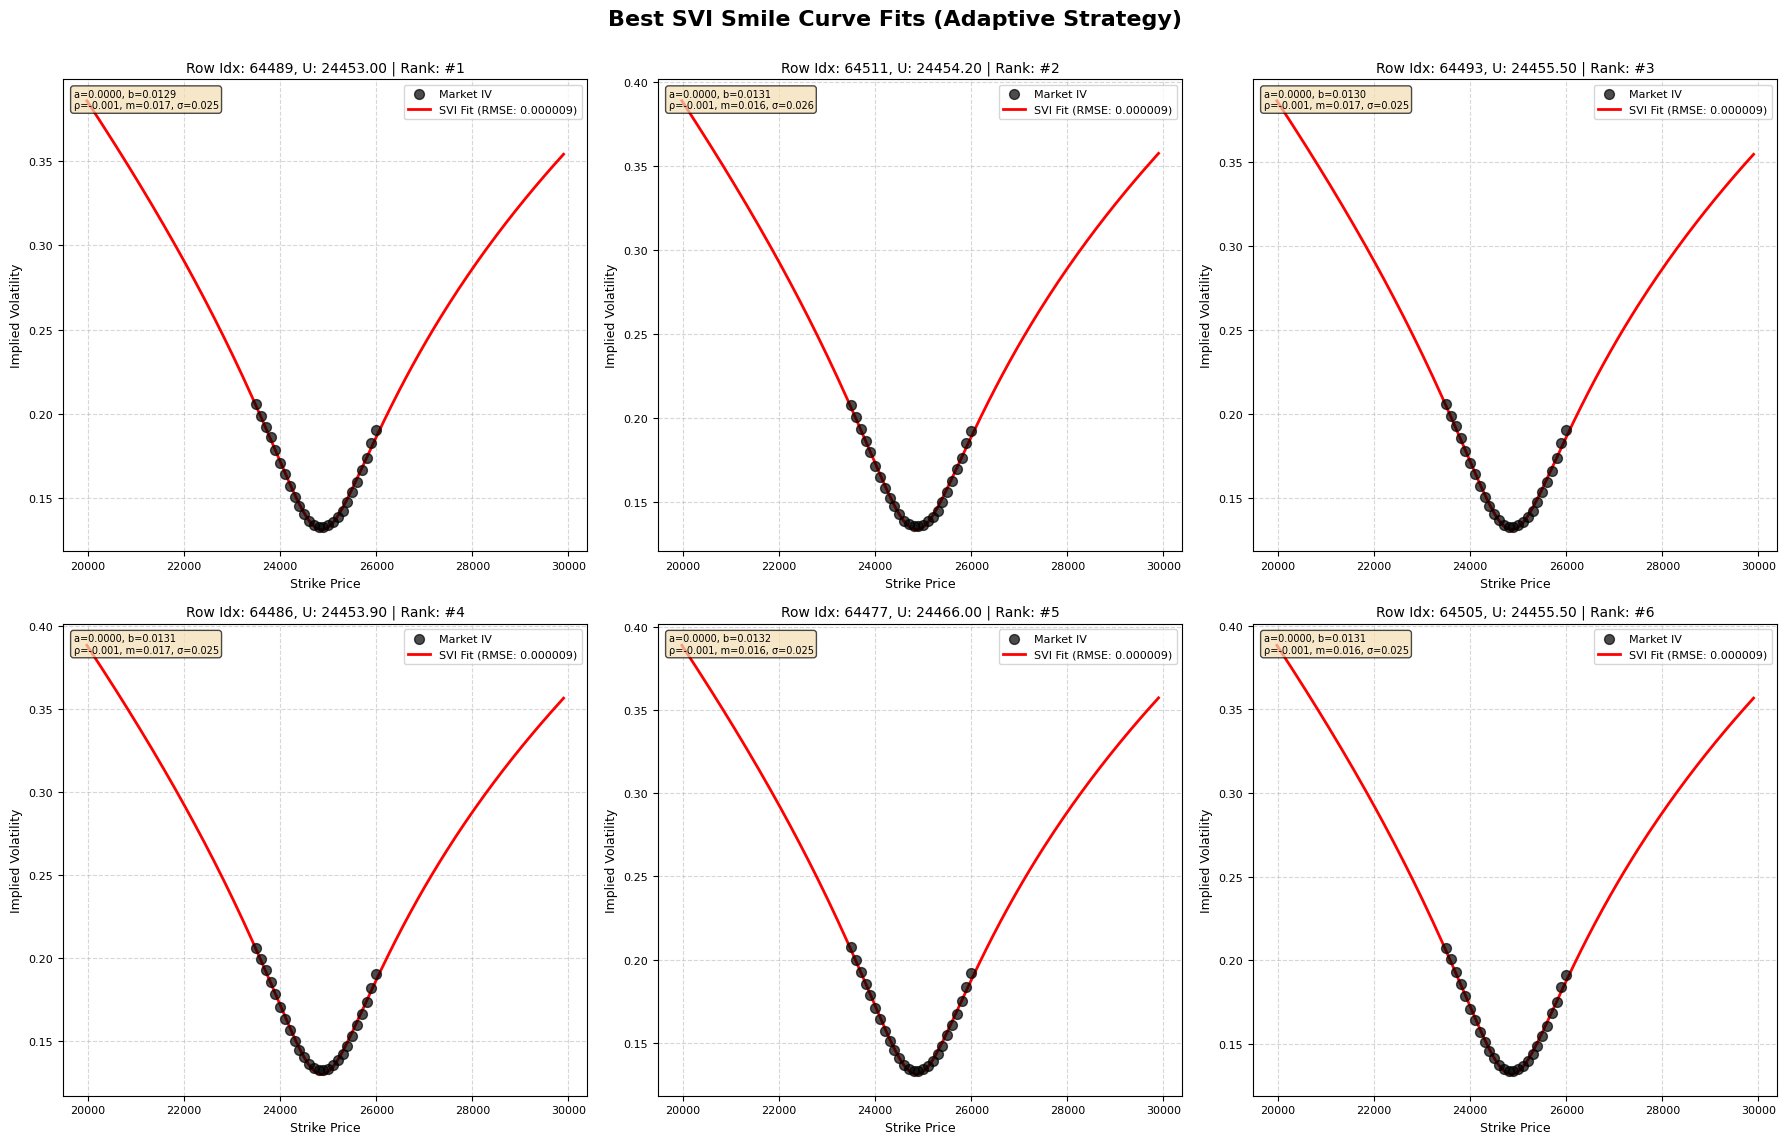

In [6]:
params_call, stats = run_svi_fitting(Y, Y.shape[0])

In [11]:
parameters = ['svi_a', 	'svi_b', 	'svi_rho', 	'svi_m', 	'svi_sigma']
final = params_call[parameters]

In [12]:
final.head()

,svi_a,svi_b,svi_rho,svi_m,svi_sigma
0,0.000044,0.014828,-0.001232,0.011064,0.023496
1,0.000033,0.014859,-0.001240,0.011137,0.024365
2,0.000036,0.014835,-0.001250,0.011226,0.024185
3,0.000033,0.014804,-0.001271,0.011414,0.024409
4,0.000030,0.014804,-0.001269,0.011396,0.024624
